# CSCI4022 Homework 4; GMMs


## Due Monday, September 27 at 11:59 pm to Canvas and Gradescope

#### Submit this file as a .ipynb with *all cells compiled and run* to the associated dropbox.

***

Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own**.

**NOTES**: 

- Any relevant data sets should be available on Canvas. To make life easier on the graders if they need to run your code, do not change the relative path names here. Instead, move the files around on your computer.
- If you're not familiar with typesetting math directly into Markdown then by all means, do your work on paper first and then typeset it later.  Here is a [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) linked on Canvas on writing math in Markdown. **All** of your written commentary, justifications and mathematical work should be in Markdown.  I also recommend the [wikibook](https://en.wikibooks.org/wiki/LaTeX) for LaTex.
- Because you can technically evaluate notebook cells is a non-linear order, it's a good idea to do **Kernel $\rightarrow$ Restart & Run All** as a check before submitting your solutions.  That way if we need to run your code you will know that it will work as expected. 
- It is **bad form** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code. 
- 45 points of this assignment are in problems.  The remaining 5 are for neatness, style, and overall exposition of both code and text.
- This probably goes without saying, but... For any question that asks you to calculate something, you **must show all work and justify your answers to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit. 
- There is *not a prescribed API* for these problems.  You may answer coding questions with whatever syntax or object typing you deem fit.  Your evaluation will primarily live in the clarity of how well you present your final results, so don't skip over any interpretations!  Your code should still be commented and readable to ensure you followed the given course algorithm.

---
**Shortcuts:**  [Problem 1](#p1) | [Problem 2](#p2) | [Problem 3](#p3) |
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm

C:\Users\zacha\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


***
<a/ id='p1'></a>
[Back to top](#top)
# Problem 1 (Theory: GMM; 5 pts) 
In the GMM slides, we stated that the weights $w_m$ of the 1-dimensional GMM with pdf

$f(x|\theta)=w_1\phi(x|\mu_1, \sigma_1^2)+w_2\phi(x|\mu_2, \sigma_2^2)+\dots+ w_m\phi(x|\mu_m, \sigma_m^2)$

required the weights to sum to one.  

#### a) Use the following markdown cell to prove this statement.  In a sentence, describe how this proof might change in higher dimensions.

In the GMM slides, we stated that the weights $w_m$ of the 1-dimension GMM with pdf

$f(x|\theta)=w_1\phi(x|\mu_1, \sigma_1^2)+w_2\phi(x|\mu_2, \sigma_2^2)+\dots+ w_m\phi(x|\mu_m, \sigma_m^2)$

required the weights to sum to one.  

For a valid pdf, we require that $\int_{-\infty}^\infty f(x) dx =1$ and that $f(x) \ge 0$ for all $x$.  Starting with integration, and using that $\int_{-\infty}^\infty \phi(x|\mu_i, \sigma_i^2) dx =1$ for all $i$:

$\int_{-\infty}^\infty f(x) dx=\int_{-\infty}^\infty w_1\phi(x|\mu_1, \sigma_1^2)+w_2\phi(x|\mu_2, \sigma_2^2)+\dots+ w_m\phi(x|\mu_m, \sigma_m^2)dx$
$=\int_{-\infty}^\infty w_1\phi(x|\mu_1, \sigma_1^2)dx+\int_{-\infty}^\infty w_2\phi(x|\mu_2, \sigma_2^2)dx+\dots+ \int_{-\infty}^\infty w_m\phi(x|\mu_m, \sigma_m^2)dx$
$=w_1\int_{-\infty}^\infty\phi(x|\mu_1, \sigma_1^2)dx+w_2 \int_{-\infty}^\infty \phi(x|\mu_2, \sigma_2^2)dx+\dots+w_m \int_{-\infty}^\infty \phi(x|\mu_m, \sigma_m^2)dx$

$=w_1 \cdot 1 + w_2 \cdot 1 + \dots + w_m\cdot 1$
$=\sum_{i=1}^m w_i$

which must equal one for a valid pdf.

The proof doesn't change at all in higher dimensions, as the integral of the multivariatenormal pdf over all the dimensions of the problem is still 1.

#### b) Is it possible to have a valid pdf $f(x)$ above if any of the weights $w_k$ are negative?  If not, why not?  If so, what other difficulties might be associated with negative weights?

In some sense, yes.  We could have a negative weight on the mixture $f(x)$ as long as there was no *specific* x-value that had negative probabiliy.  In 1-d, it would look like we'd just taken a small chunk out of the overall distribution.

In practice, this has a major problem: we use GMMs sometimes as a *generative* model, and there's no longer a valid probability measure associated with the choosing a mixture!  So while we could write down the complete pdf with all of our components, we could no longer easily simulate from it, nor in truth view it as a "mixture," since the mixtures would no longer be from a (discrete) probability distribution.

***

<a/ id='p2'></a>
[Back to top](#top)
# Problem 2 (Choose a k? 25 pts)

Recall our dataset from HW03 that tracks earthquakes in an area around Fiji.  It contains:

`lat`: numeric,	Latitude of event

`long`:	numeric,	Longitude

`depth`: numeric,	Depth (km)

`mag`:	numeric	Richter Magnitude

`stations`:	numeric	Number of stations reporting

For all prompts, use Euclidean distance ($L_2$).

(**NB**: using Euclidean distance on lat/lon data is not technically correct, you classically have to *project* locations onto a 2D map or find their true great-circle distances apart.  We will ignore this here, as the region is small enough to have only minor error due to ignoring curvature of the surface.)

Here we will focus on the locational problem of just latitude versus longitude.  Instead of just choosing $k$ as we did before, we might choose a variety of values of $k$ and implement a GMM for each.

Shown below is the lat/lon locations of the earthquakes.  Not only is there structure, it has a shape: some data appears in lines that aren't perfect circles.  This is a perfect task for the GMM!

     lat    long  depth  mag  stations
0 -20.42  181.62    562  4.8        41
1 -20.62  181.03    650  4.2        15
2 -26.00  184.10     42  5.4        43
3 -17.97  181.66    626  4.1        19


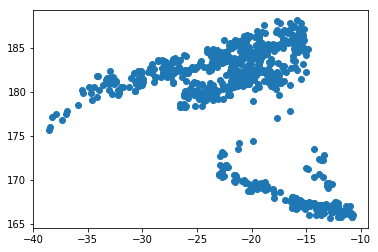

In [2]:
df=sm.datasets.get_rdataset('quakes').data
print(df.head(4))
plt.scatter(df['lat'], df['long'])
df=df[['lat', 'long']]

**Part A**:  Write (by hand) a function `GMM(dat, k, init=...)` that performs the EM algorithm for a Gaussian mixture model on a given set of $(X,Y)$ locational data.  You may include random initialization inside the function or as an input.

You should run the algorithm for sufficient steps until convergence, and should return at a minimum, the means, 2x2 covariance matrices, and mixture probabilities of each component.  You may also want to return the responsibilities of each datum to the k components for later use, but this is less necessary.

In [3]:
def GMM(dat, k):
    p_class=np.zeros(k)
    means=np.zeros((k,2))
    covars=np.zeros((k,2,2))
    mean_dist=np.array(0)
    p_data_given_class=np.zeros((len(dat),k))
    #initializations
    init_idx=np.random.choice(range(len(dat)), size=k, replace=False)
    
    for dim in range(k):
        covars[dim,:,:]=np.cov(np.transpose(dat))
        means[dim,:]=dat.iloc[init_idx[dim]]
        p_class[dim]=1/k
        
    for step in range(50):  
        #Bayes stuff: pdfs then pdf*mixtures, then normalize
        for dim in range(k):
            p_data_given_class[:,dim]=  np.array([stats.multivariate_normal.pdf(x=dat, mean=means[dim,:], cov=covars[dim,:,:])])
        p_class_given_data=p_data_given_class*p_class

        sums=np.sum(p_class_given_data, axis=1)
        for dim in range(k):
            p_class_given_data[:,dim]=p_class_given_data[:,dim]*(1/sums)
        n_class = np.sum(p_class_given_data, axis=0)
        p_class=n_class/len(dat)

        # mean and covar updates
        for dim in range(k):
            means[dim,0]=np.sum(p_class_given_data[:,dim]*dat.iloc[:,0])*(1/n_class[dim])
            means[dim,1]=np.sum(p_class_given_data[:,dim]*dat.iloc[:,1])*(1/n_class[dim])
            X_new=dat.copy()
            X_new.iloc[:,0]=X_new.iloc[:,0]-means[dim,0]
            X_new.iloc[:,1]=X_new.iloc[:,1]-means[dim,1]
            
            covars[dim,:,:]=np.matmul((X_new.T)*(p_class_given_data[:,dim]),X_new)/(n_class[dim])
#             covars[dim,0,0]=np.sum(p_class_given_data[:,dim]*((dat.iloc[:,0]-means[dim,0])**2))*(1/n_class[dim])
#             covars[dim,1,1]=np.sum(p_class_given_data[:,dim]*((dat.iloc[:,1]-means[dim,1])**2))*(1/n_class[dim])                                                      
#             covars[dim,0,1]=np.sum(p_class_given_data[:,dim]*(dat.iloc[:,1]-means[dim,1])*(dat.iloc[:,0]-means[dim,0]))*(1/n_class[dim])                                                      
#             covars[dim,1,0]=np.sum(p_class_given_data[:,dim]*(dat.iloc[:,1]-means[dim,1])*(dat.iloc[:,0]-means[dim,0]))*(1/n_class[dim])                                                      
    
    mean_dist=0
    for pt in range(len(dat)):
        for dim in range(k):
            #for each datum-mean pair, compute their prob-weighted distance apart
            mean_dist+=np.sqrt(np.sum((means[dim,:]-np.array(dat.iloc[pt]))**2)*p_class_given_data[pt,dim])
    mean_dist=mean_dist/(len(dat)*k)
    return p_class_given_data, means, covars, p_class, mean_dist

**Part B**: 

Run your algorithm for $k=[1,2,3,4,5,6,7,8]$, then create an **elbow plot** of the weighted-mean-distance to component for each choice of $k$.

To compute this, take a clustering and its responsibilities $p_{mi}$, then compute the average distance between each point and each cluster, weighted by $p_{mi}$:

$$ \bar{D} = \sqrt{\frac{\sum^n_{i=1}\sum^k_{m=1} p_{mi} (x_i-\mu_m)^2}{n}}$$

(**Idea**: this averages the distance between each point and the 'closest' cluster, but allows for the soft-clustering nature of points to compute distances between multiple clusters.)


Create your elbow plot by making a line plot of the values of $\bar{D}$ against $k$.

In [4]:
pmi1, mu1, sig1, p1, d1 = GMM(df,1)
pmi2, mu2, sig2, p2, d2 = GMM(df,2)
pmi3, mu3, sig3, p3, d3 = GMM(df,3)
pmi4, mu4, sig4, p4, d4 = GMM(df,4)
pmi5, mu5, sig5, p5, d5 = GMM(df,5)
pmi6, mu6, sig6, p6, d6 = GMM(df,6)
pmi7, mu7, sig7, p7, d7 = GMM(df,7)
pmi8, mu8, sig8, p8, d8 = GMM(df,8)



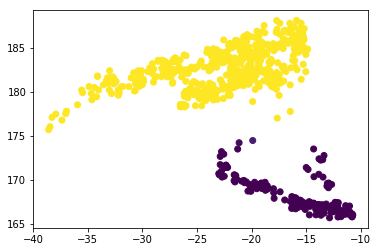

In [5]:
#bonus plot of k=2 to make sure it's passing sanity check

plt.scatter(df['lat'], df['long'], c=pmi2[:,0])

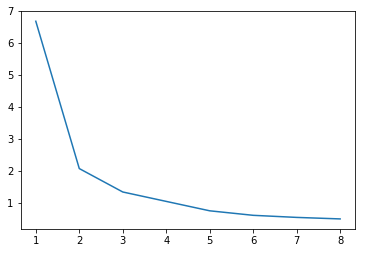

In [6]:

plt.plot([1,2,3,4,5,6,7,8], [d1,d2,d3,d4,d5,d6,d7,d8])

**Part C**: 

Based on the plot in part **B**, what looks like the best choice of $k$ for this problem?  Are multiple values in contention?  Explain, and then plot your preferred choice of $k$ where you color each data point according to the cluster with which it has the highest responsibility (i.e. hard cluster based on responsibilities).

We definitely need at least a second cluster, but after that it's not clear where the best jump is.  3 and 5 both look reasonable for these runs, but your plot may depend on initialization!

***
<a/ id='p3'></a>
[Back to top](#top)
# Problem 3 (Simulation on the GMM; 15 pts)


Because the GMM is a *generative* model, we could use our results from Problem 2 to not only score models based on their mean-distance-to-centroid (or other statistical measures like AIC, BIC), we could simulate points from the models and visually ascertain whether or not they appear similar to the original distribution.

**Part A**: 

For each of the GMM models in Problem 2 from $k=[2,3,4,5,6,7,8]$, simulate 1000 points from your estimated density function (recall: this is a two-part simulation of choosing a component **then** drawing from the normal of appropriate mean/covariance).

Create a figure with 2 columns and 4 rows holding all 8 data sets: the 7 simulated ones and the original data shown above.  Label each plot appropriately.  

In [8]:

sim2=np.zeros((len(df), 2))
sim3=np.zeros((len(df), 2))
sim4=np.zeros((len(df), 2))
sim5=np.zeros((len(df), 2))
sim6=np.zeros((len(df), 2))
sim7=np.zeros((len(df), 2))
sim8=np.zeros((len(df), 2))

for i in range(len(df)): 
    cluster=np.random.choice(range(2), p=p2)
    sim2[i,:]=stats.multivariate_normal.rvs(mean=mu2[cluster,:], cov=sig2[cluster,:,:])
    
    cluster=np.random.choice(range(3), p=p3)
    sim3[i,:]=stats.multivariate_normal.rvs(mean=mu3[cluster,:], cov=sig3[cluster,:,:])
    
    cluster=np.random.choice(range(4), p=p4)
    sim4[i,:]=stats.multivariate_normal.rvs(mean=mu4[cluster,:], cov=sig4[cluster,:,:])
    
    cluster=np.random.choice(range(5), p=p5)
    sim5[i,:]=stats.multivariate_normal.rvs(mean=mu5[cluster,:], cov=sig5[cluster,:,:])
    
    cluster=np.random.choice(range(6), p=p6)
    sim6[i,:]=stats.multivariate_normal.rvs(mean=mu6[cluster,:], cov=sig6[cluster,:,:])
    
    cluster=np.random.choice(range(7), p=p7)
    sim7[i,:]=stats.multivariate_normal.rvs(mean=mu7[cluster,:], cov=sig7[cluster,:,:])
    
    cluster=np.random.choice(range(8), p=p8)
    sim8[i,:]=stats.multivariate_normal.rvs(mean=mu8[cluster,:], cov=sig8[cluster,:,:])
    

Text(0.5,1,'k=8 GMM Sim')

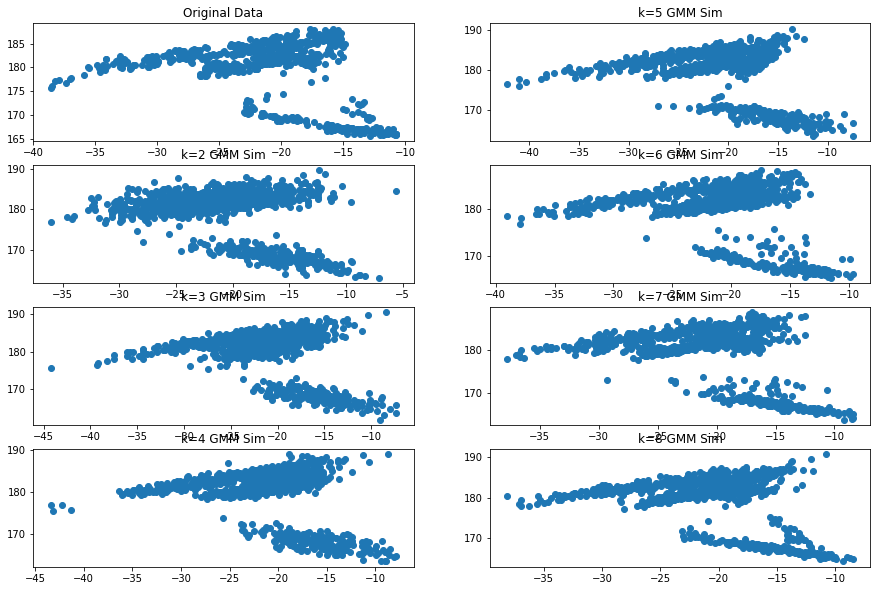

In [9]:
fig, ax = plt.subplots(figsize=(15,10), nrows=4, ncols=2)
ax[0,0].scatter(df['lat'], df['long'])
ax[0,0].set_title('Original Data')
ax[1,0].scatter(sim2[:,0],sim2[:,1])
ax[1,0].set_title('k=2 GMM Sim')
ax[2,0].scatter(sim3[:,0],sim3[:,1])
ax[2,0].set_title('k=3 GMM Sim')
ax[3,0].scatter(sim4[:,0],sim4[:,1])
ax[3,0].set_title('k=4 GMM Sim')


ax[0,1].scatter(sim5[:,0],sim5[:,1])
ax[0,1].set_title('k=5 GMM Sim')
ax[1,1].scatter(sim6[:,0],sim6[:,1])
ax[1,1].set_title('k=6 GMM Sim')
ax[2,1].scatter(sim7[:,0],sim7[:,1])
ax[2,1].set_title('k=7 GMM Sim')
ax[3,1].scatter(sim8[:,0],sim8[:,1])
ax[3,1].set_title('k=8 GMM Sim')


**Part B**: 


Which plot or plots look closest to the original data?  Depending on your interpretations of the elbow plot versus the simulated data, you may have decided that we wanted a different value of $k$ for the best model to *simulate* from rather than the best model to *cluster* or classify upon.  Do you think that this is normally the case?  Why or why not?  What properties of a data set would make one task easier or harder with more or less $k$?

It seems like we need at least $k=4$ or $k=5$ to capture that the upper island has an assymetry (the southern half is less wide than the northern half).  Most of the runs struggle with the points between the two islands, but around k=6 to k=8 these start getting a little better, at least *exist*.  

Generally, we need more $k$ if we want to simulate since we're trying to actually capture *shape*.  This means we want to maintain most or much of the original structure of the data, whereas for clustering we're often just trying to *reduce* the data to much simpler descriptions like "north island or south."

In either case, having non-linear aspects like curves or asymmetric shapes make the process more prone to error and require many more clusters to properly estimate!